# BNN on Pynq

This notebook covers how to use Binary Neural Networks on Pynq. 
It shows an example of image recognition with a binarized neural network inspired at VGG-16, featuring 6 convolutional layers, 3 max pool layers and 3 fully connected layers

## 1. Instantiate a Classifier
Creating a classifier will automatically download the correct bitstream onto the device and load the weights trained on the specified dataset. By default there are three sets of weights available for the BNN version of the CNV network using 1 bit weights and 1 activation (W1A1) - this example uses the German Road Sign dataset.

In [1]:
import bnn
print(bnn.available_params(bnn.NETWORK_CNVW2A2))

classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW2A2, 'aedes', bnn.RUNTIME_HW)

['aedes', 'cifar10']


## 2. List the available classes
The selected dataset can classify images in 42 classes, the names of which are accessible through the classifier.

In [2]:
print(classifier.classes)

['Bacia', 'Garrafa', 'Garrafao', 'Jarro', 'Pneu']


## 3. Locate objects within a scene

This example is going to create an array of images from a single input image, tiling the image to try and locate an object. This image shows a road intersection and we're aiming at finding the stop sign.

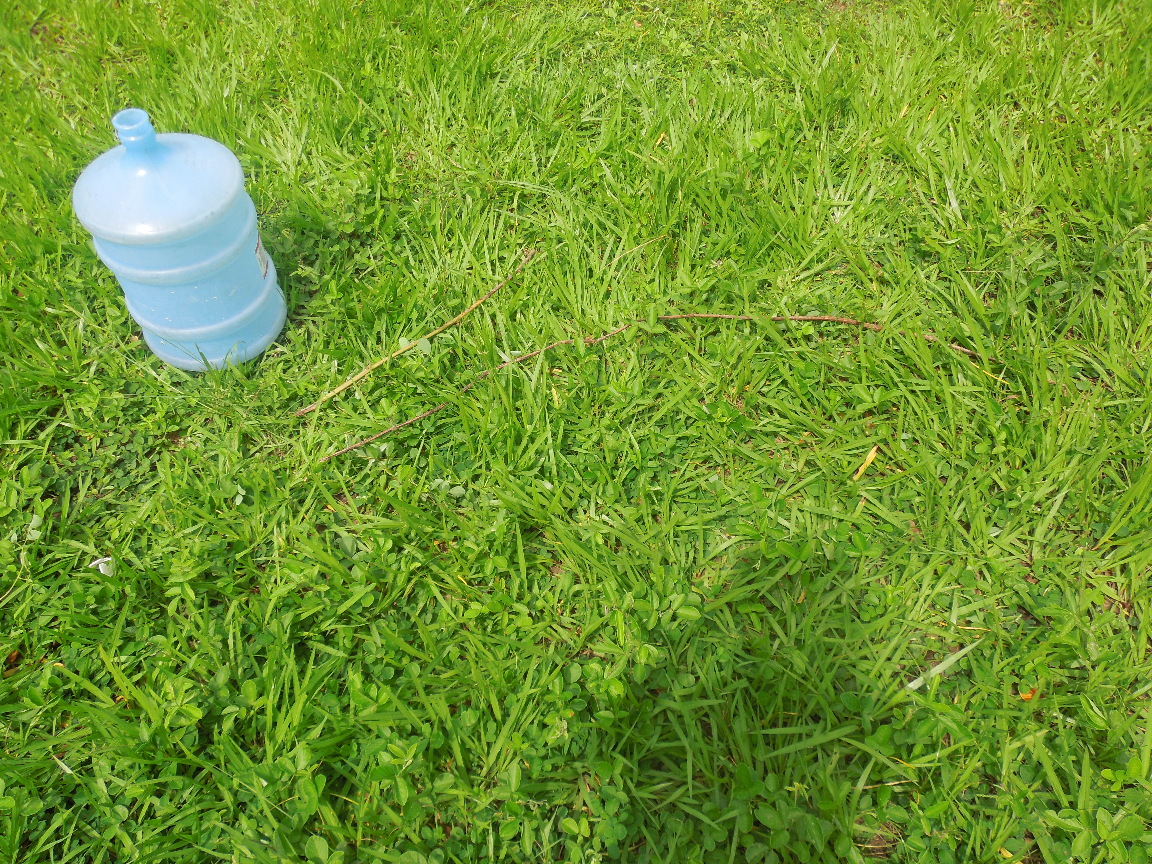

In [3]:
from PIL import Image
image_file = "/home/xilinx/jupyter_notebooks/bnn/data/DSCN3020.JPG"
im = Image.open(image_file)
im=im.resize(size=(int(im.size[0]/4),int(im.size[1]/4)))
im

Here we launch the classification on all the tiles from the source image, and all image in which the BNN identified a STOP signal is shown

In [4]:
images = []
bounds = []
for s in [96*3,64*3]:
    stride = s // 8
    x_tiles = im.width // stride
    y_tiles = im.height // stride
    
    for j in range(y_tiles):
        for i in range(x_tiles):
            bound = (stride * i, stride * j, stride * i + s, stride * j + s)
            if bound[2] <= im.width and bound[3] < im.height:
                c = im.crop(bound)
                images.append(c)
                bounds.append(bound)

print(len(images))
images

1548


[<PIL.Image.Image image mode=RGB size=288x288 at 0xA90D56B0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5730>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5770>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D57B0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D57F0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xB3AF64B0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xB3AF67B0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xB3AF6AB0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5890>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5850>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D58D0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5910>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5950>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5990>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D59D0>,
 <PIL.Image.Image image mode=RGB size=288x288 at 0xA90D5A10>,
 <PIL.Im

Inference took 1803128.99 microseconds, 1164.81 usec per image
Classification rate: 858.51 images per second


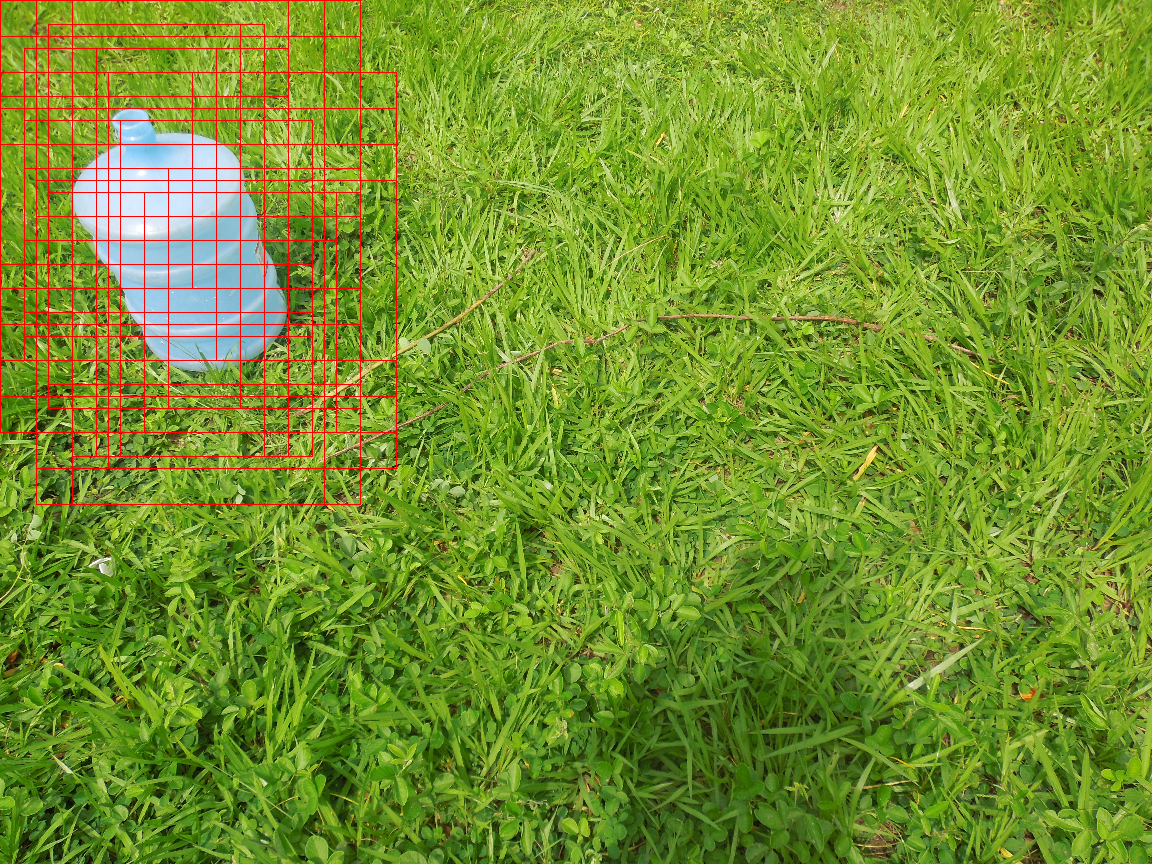

In [5]:
results = classifier.classify_images(images)
stop = results == 2
indicies = []
indicies = stop.nonzero()[0]
from PIL import ImageDraw
im2 = Image.open(image_file)
im2=im2.resize(size=(int(im2.size[0]/4),int(im2.size[1]/4)))
draw2 = ImageDraw.Draw(im2)
for i in indicies:
    draw2.rectangle(bounds[i], outline='red')

im2

(Optional) the classification can be post-analyzed in order to pick only tiles in which the STOP signal is identified with a score higher than a certain threshold

Inference took 1803129.94 microseconds, 1164.81 usec per image
Classification rate: 858.51 images per second


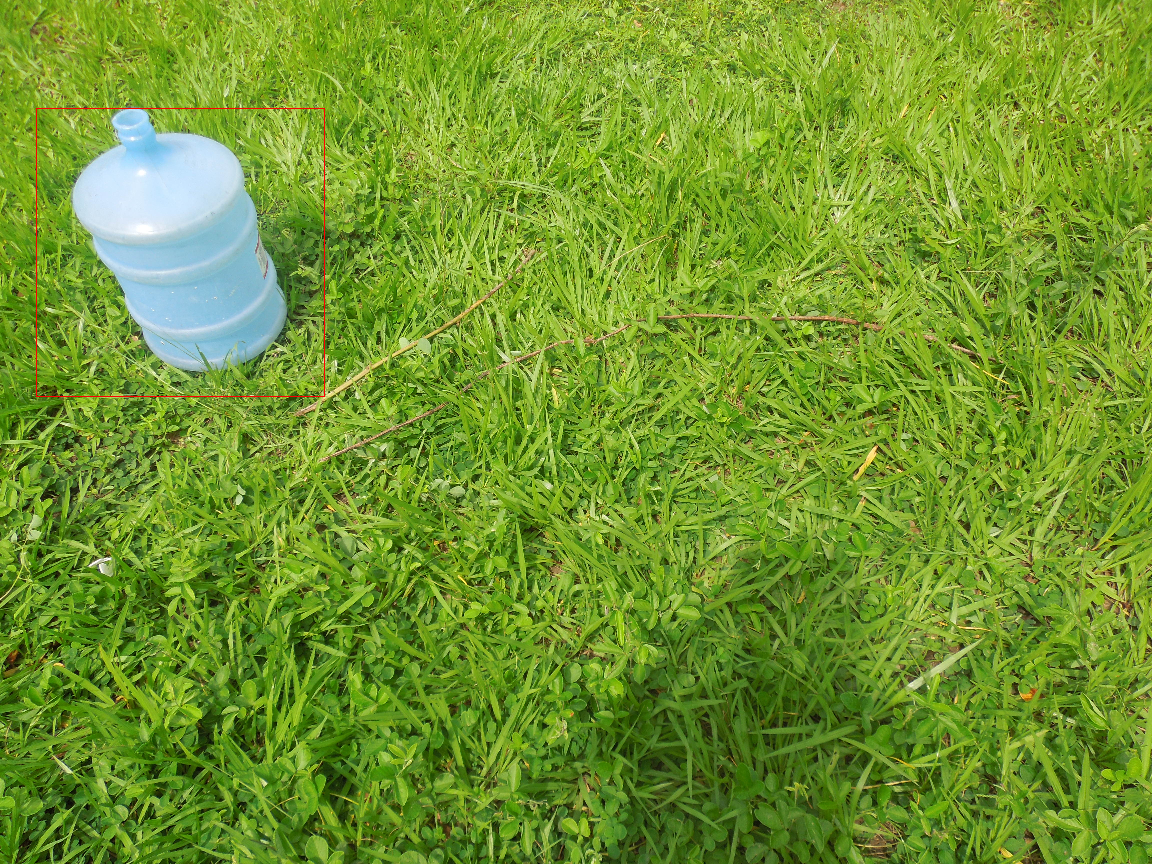

In [6]:
result = classifier.classify_images_details(images)
result=result.reshape(len(images),5)

import numpy as np
i=np.argmax(result[:,2])
from PIL import ImageDraw

draw = ImageDraw.Draw(im)
draw.rectangle(bounds[i], outline='red')    
im

## 7. Reseting the device

In [7]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()